# Notebook: *k*-means and GMM for clustering

In this notebook, we present the *k*-**means** and **Gaussian Mixture Models** algorithms. In this notebook, we will cover a basic understanding of the **Expectation Maximization (EM)** algorithm which, not only forms the basis of several machine learning algorithms, including *k*-means, and Gaussian Mixture Models, but also has lots of applications. We will also cover the *k*-means algorithm which is a form of EM, and its weaknesses. Finally we will discuss how Gaussian Mixture Models improve on several of *k*-means weaknesses.

## Contents
The structure of the notebook is as follows:
* Introducing *k*-means
* *k*-means Algorithm: Expectation–Maximization
* Clustering on real data: SNPs Database
* Weaknesses of *k*-means
* Generalizing E–M: Gaussian Mixture Models


## Sources
<!--BOOK_INFORMATION-->
*This notebook has been modified by Aythami Morales from:

i) [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas.

ii) [Intro to Expectation-Maximization, K-Means, Gaussian Mixture Models with Python, Sklearn](http://www.blackarbs.com/blog/intro-to-expectation-maximization-k-means-gaussian-mixture-models-with-python-sklearn/3/20/2017)

iii) [GMM covariances](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py) by Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>




## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
# sklearn includes kmeans algorithm
from sklearn.cluster import KMeans

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

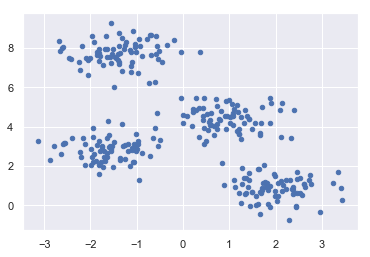

In [2]:
# male_blobs is a function used to create synthetic data that can be used to test algorithms
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=20);
#print(len(y_true))

By eye, it is relatively easy to pick out the four clusters. The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [3]:
# two of the most important paremeters of k-means are the number of clusters and the initialization
# here we will use four clusters and random initialization
kmeans = KMeans(n_clusters=4)

# estimate model parameters with the EM algorithm
kmeans.fit(X)

# predict the closest cluster each sample in X belongs to
y_kmeans = kmeans.predict(X)


Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

[[ 0.94973532  4.41906906]
 [ 1.98258281  0.86771314]
 [-1.58438467  2.83081263]
 [-1.37324398  7.75368871]]
[ 0.94973532  1.98258281 -1.58438467 -1.37324398]


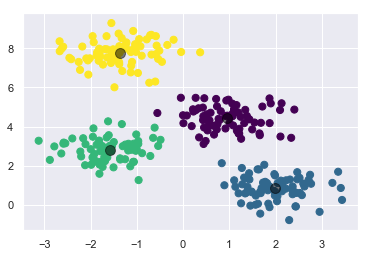

In [4]:
# plot the original data and the predicted clusters
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# plot the cluster centers
centers = kmeans.cluster_centers_
print(centers)
print(centers[:, 0])
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## k-means algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here. In short, the expectation–maximization approach here consists of the following procedure:
Guess some cluster centers
Repeat until converged
E-Step: assign points to the nearest cluster center
M-Step: set the cluster centers to the mean 
Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to. The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.
The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

The *k*-means algorithm is simple enough that we can write it in a few lines of code. See ./my_modules/my_module.py for a complete implementation of the algorithm

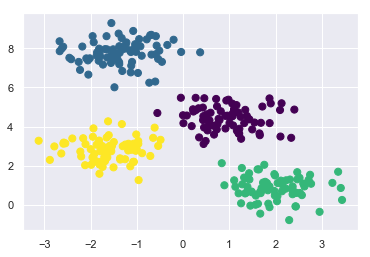

In [5]:
# add your modules to the path
import sys
import os

sys.path.append(os.getcwd() + "/my_modules")

# my_module is an example of python module created to include your functions
import my_module

# in the function my_module.find_cluster you have a simple implementation of the k-means algortihm
# the output of the function are the centers of the clusters and the labels asigned to each data sample
centers, labels = my_module.find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Let's see how it works step by step

In [6]:
%matplotlib inline
# we can modify the number of clusters and see step by step the results of the EM algorithm.
my_module.plot_kmeans_interactive(min_clusters=2, max_clusters=8);

interactive(children=(Dropdown(description='frame', options=(0, 50), value=0), Dropdown(description='n_cluster…

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

## Clustering on real data: SNPs Database

To start, let's take a look at applying *k*-means on the same data used for the previous notebook (notebook 2 PCA). Here we will attempt to use *k*-means to try to identify similar SNPs clusters; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information. 

First, we will repeat the PCA analysis done in previous notebook without the population and superpopulation data.

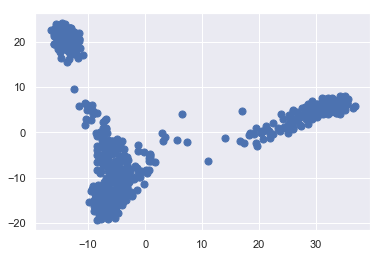

In [7]:
from sklearn.decomposition import PCA
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# read the SNP table
df_snp = pd.read_csv('./data/geno_table.txt', delimiter='\t',
                     index_col='snp_id').transpose()

# convert the dato to type float
df_snp = df_snp.astype(np.float)

# standardize the data before performing PCA
# we use .drop to remove the gender, pop and super_pop columns to avoid errors.
df_snp_std = sklearn.preprocessing.StandardScaler().fit_transform(
                            df_snp)

# define the number of components of the PCA domain
n_components=50
snp_pca = PCA(n_components=n_components)

# project the data into this new PCA space
snp_pca.fit(df_snp_std)
df_snp_pca = snp_pca.transform(df_snp_std)

# convert dataframe to array
X=np.array(df_snp_pca)

# plot first two PC without labels
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis');

Secondly, we will show the projected data without labels (prior information).

As we can see, some clusters can be easily identified. The goal now is to use *k*-means to automatically locate such clusters. In the ideal case, the clusters will be similar to superpopulation labels available in the training data.

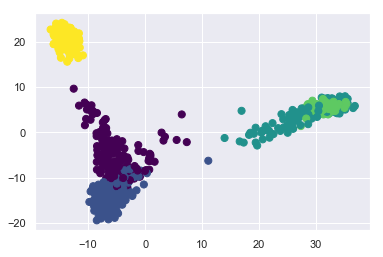

In [8]:
# perform k-means clustering
centers, labels = my_module.find_clusters(X, 5)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Now we plot the original labels to compare with our clustering prediction.

Remember that real labels were available from the information provided with the database: 
![alt text](./data/PCA_results.png)


The results show how *k*-means has correctly grouped SNPs data from all superpopulations except for the African subjects (grouped into two clusters). Note that information about the population or superpopulation was not used during PCA training and *k*-means clustering.

## Weaknesses of k-Means

Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.
As we saw in the previous section, given simple, well-separated data, *k*-means finds suitable clustering results.

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved:
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

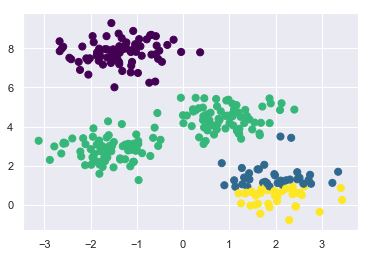

In [9]:
# male_blobs is a function used to create synthetic data that can be used to test algorithms
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

# we will modify the seed of the random initialization of the centroids
centers, labels = my_module.find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');


Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:



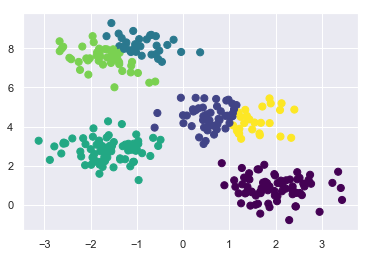

In [10]:
# we repeat the kmeans with 6 clusters
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

#### k-means is limited to linear cluster boundaries

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them.
Unfortunately, the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalizing the model.

One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualize this cluster model with the following function:

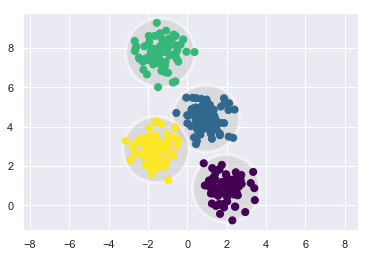

In [11]:
# once again, we execute kmeans with four clusters
kmeans = KMeans(n_clusters=4, random_state=0)

#let's plot the clustering as a sphere
my_module.plot_kmeans(kmeans, X)

An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

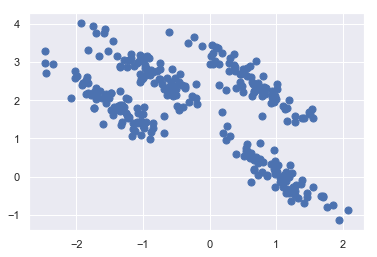

In [12]:
# we read a new synthetic data with an elliptical shape
X_stretched = np.load("./data/data_stretched.npy")
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], s=50);

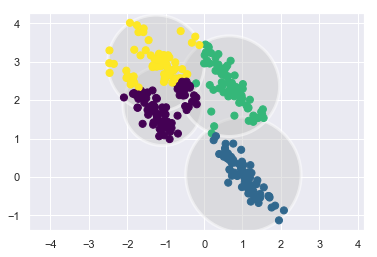

In [13]:
# repeat the k-means algorithm with four clusters for this new dataset
kmeans = KMeans(n_clusters=4, random_state=0)
my_module.plot_kmeans(kmeans, X_stretched)


The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

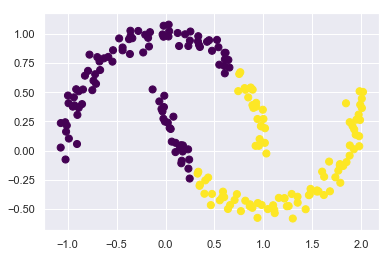

In [14]:
# make_moons allows to generate synthetic data to test algorithms
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

# run the k-means algorithm  with two clusters
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.
One might imagine addressing this particular situation by preprocessing the data with PCA (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)), but in practice there is no guarantee that such a global operation will circularize the individual data.

These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

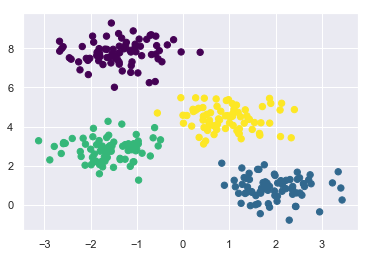

In [15]:
# import the Gaussian Mixture Model algorithm from sklearn
from sklearn.mixture import GaussianMixture as GMM

# make_blobs is a function used to create synthetic data that can be used to test algorithms
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

# estimate model parameters with the EM algorithm, we will use four gaussian functions
gmm = GMM(n_components=4).fit(X)

# predict the labels for the data samples in X using trained model
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [16]:
# predict posterior probability of each component given the data
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.972 0.002 0.026]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.999 0.    0.001]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

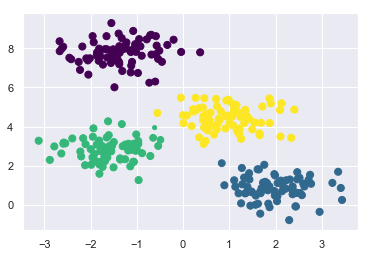

In [17]:
# square emphasizes differences
size = 50 * probs.max(1) ** 2 
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

We can take a look at what the four-component GMM gives us for our initial data:

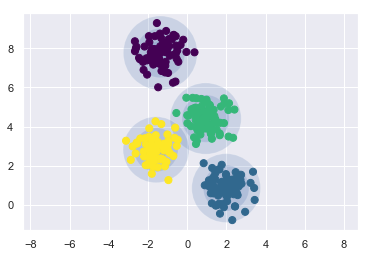

In [18]:
# estimate model parameters with the EM algorithm using four gaussians, initialization seed and spherical covariance 
gmm = GMM(n_components=4, random_state=42, covariance_type='spherical')
my_module.plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

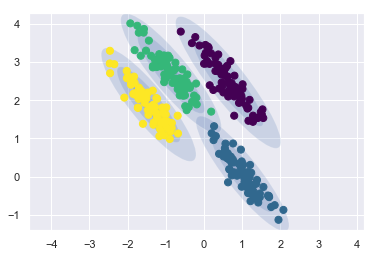

In [19]:
# we read a new synthetic daya with an elliptical shape
X_stretched = np.load("./data/data_stretched.npy")

# estimate model parameters with the EM algorithm using four gaussians, random initialization and full covariance 
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
my_module.plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function.

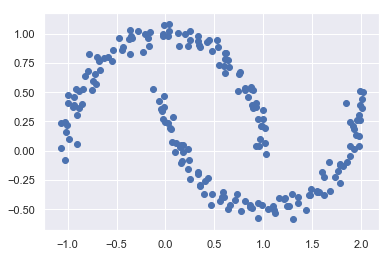

In [20]:
# make_moons allows to generate synthetic data to test algorithms
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

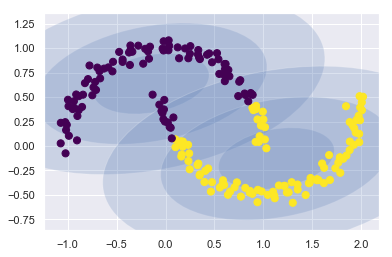

In [21]:
# estimate model parameters with the EM algorithm using two gaussians, initialization seed and full covariance 
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
my_module.plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

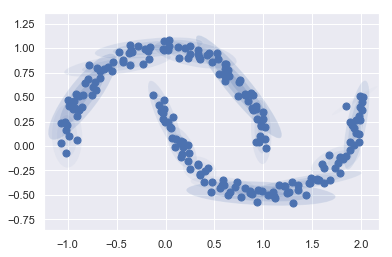

In [22]:
# estimate model parameters with the EM algorithm using sixteen gaussians, initialization seed and full covariance 
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
my_module.plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

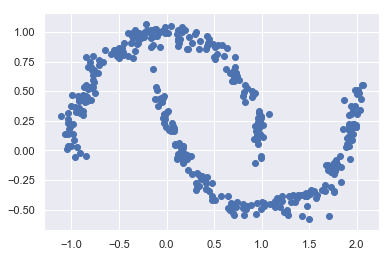

In [23]:
# generate 400 new random samples from the fitted Gaussian distribution.
[Xnew, ynew] = gmm16.sample(n_samples=400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

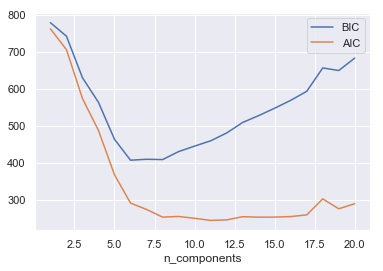

In [24]:
# define a list of number of components (gaussian functions) to be evaluated
n_components = np.arange(1, 21)

# estimate models parameters with the EM algorithm and the list of components
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

# plot the results of the AIC and BIC estimators (models.bic and models.aic)
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.


## Task


Using the *Wisconsin Diagnostic Breast Cancer* employed in the previous PCA notebook (available in the ./data folder of this notebook), the students will perform the following tasks: 
 
 a) Read the dataset.
 
 b) Perform a PCA analysis over the data.
 
 c) Project the data into the PC space.
 
 d) Apply both k-means and GMM over the projected data.
 
 e) Compare the obtained clusters with the real labels.

### Methods

In [25]:
def draw_vector(v0, v1, ax=None):
    """
    Draw vector from position v0 to v1
    """
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='-',
                    linewidth=4,
                    color='g',
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
def get_component_number(file, desired_variance=99.0, delimiter='\t', index_col='snp_id'):
    """ 
    Obtain the number of components that explains a %desired_variance
    Args:
        file (str): path of the file with snp data
        delimiter (str): field delimiter of file
        index_col (str): name of the column that serves as index
        desired_variance (float): desired explained variance
    Returns:
        int: number of components to maintain to have a explained variance >= desired_variance
        float: variance explained for the nunber of components returned
        numpy array: cumulative variance by number of components retained
    """  
    df_snp = pd.read_csv(file, delimiter=delimiter, index_col=index_col).transpose().astype(np.float)
    return get_component_number_from_data(df_snp, desired_variance=desired_variance, scaling = True)

def get_component_number_from_data(df_data, desired_variance=99.0, scaling=False):
    """ 
    Obtain the number of components that explains a %desired_variance
    Args:
        df_data (dataframe): dataframe of features in cols and samples in rows
        desired_variance (float): desired explained variance
        scaling (boolean): True if pre-scaling is needed prior to compute PCA
    Returns:
        int: number of components to maintain to have a explained variance >= desired_variance
        float: variance explained for the nunber of components returned
        numpy array: cumulative variance by number of components retained
    """  
    if scaling:
        df_data = sklearn.preprocessing.StandardScaler().fit_transform(df_data)
    # project the data into this new PCA space
    pca = PCA().fit(df_data)
    
    desired_variance = desired_variance/100.0
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    component_number = 0
    for cumulative_variance in explained_variance:
        component_number += 1
        if cumulative_variance >= desired_variance:
            break
    return component_number, cumulative_variance, explained_variance



def plot_component_number(component_number, cumulative_variance, explained_variance, x_interval=3):
    """
    Plot number of components into cumulative variance curve.
    Args:
        component_number (int): number of components to maintain to have a explained variance >= desired_variance
        cumulative_variance (float): variance explained for the nunber of components returned
        explained_variance (numpy array): cumulative variance by number of components retained
        x_interval (int): length of plot interval for the number of components (x axis)
    """
    plt.plot(list(range(1, len(explained_variance) + 1)), explained_variance)
    plt.xlim(component_number - x_interval, component_number + x_interval)
    ylim_bottom = explained_variance[component_number - x_interval - 1]
    ylim_top = explained_variance[component_number + x_interval - 1]
    plt.ylim(ylim_bottom, ylim_top)
    draw_vector([component_number, ylim_bottom], [component_number, cumulative_variance])
    draw_vector([component_number - x_interval, cumulative_variance], [component_number, cumulative_variance])

    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');



### PCA

Number of components for cumulative variance >= 99%:  2
Cumulative variance for number of components 2:  0.9982211613741726


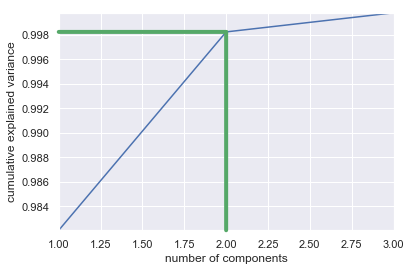

In [26]:
# Calculate number of components to retain 99% of variance
data = pd.read_csv('./data/wdbc.csv',header=None)
wdbc = data.values[ :, 2:].astype(np.float)

desired_variance = 99
component_number, cumulative_variance, explained_variance =\
    get_component_number_from_data(wdbc, desired_variance)
print("Number of components for cumulative variance >= " + str(desired_variance) + "%: ", component_number)
print("Cumulative variance for number of components " + str(component_number) + ": ", cumulative_variance)
plot_component_number(component_number, cumulative_variance, explained_variance, x_interval=1)


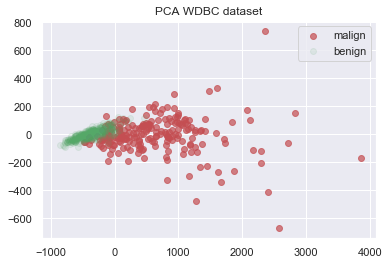

In [27]:
# generate PCA for number of components previously calculated
pca = PCA(n_components=component_number) 
wdbc_pca = pca.fit(wdbc).transform(wdbc).astype(np.float)

# project the data into this new PCA space
plt.figure()
comp1=0; #first component to visualize, you can modify it
comp2=1; #second component to visualize, you can modify it

labels = (data.values[ :, 1 ] == 'B').astype(np.int)

# plot the two components selected above for both malign and benign tumors
plt.scatter(wdbc_pca[labels == 0, comp1], wdbc_pca[labels == 0, comp2], color='r', alpha=.7, lw=1,
                label='malign')

plt.scatter(wdbc_pca[labels == 1, comp1], wdbc_pca[labels == 1, comp2], color='g', alpha=.1, lw=1,
                label='benign')

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA WDBC dataset')

plt.show()

### K-means E-M

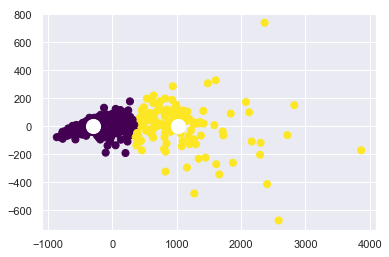

In [32]:
kmeans = KMeans(n_clusters=2)

# estimate model parameters with the EM algorithm
kmeans.fit(wdbc_pca)

# predict the closest cluster each sample in wdbc_pca belongs to
y_kmeans = kmeans.predict(wdbc_pca)

# plot the original data and the predicted clusters
plt.scatter(wdbc_pca[:, 0], wdbc_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')

# plot the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=200, alpha=1.0);

### K-means GMM

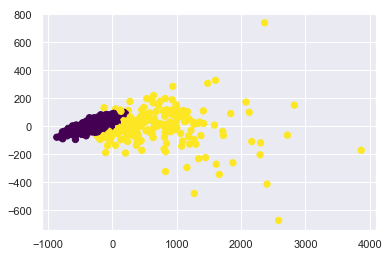

In [31]:
# estimate model parameters with the EM algorithm, we will use four gaussian functions
gmm = GMM(n_components=2).fit(wdbc_pca)
# predict the labels for the data samples in X using trained model
labels = gmm.predict(wdbc_pca)
#centers = gmm.cluster_centers_
plt.scatter(wdbc_pca[:, 0], wdbc_pca[:, 1], c=labels, s=40, cmap='viridis');

### Comparing results